## Cyber Security Job Market Data Analysis and Visualization

### Motivation and objectives

The cybersecurity job market is constantly evolving and growing, and even when there's a high demand of professionals on this area, Europe faces a shortage of cybersecurity professionals. 
Studying the cybersecurity job market is crucial for understanding the significant demand, evolving trends, and diverse opportunities available in this important and growing field. 

The objective of this project is to collect, enrich, explore, analyze and visualize cybersecurity job market needs. This knowledge can help individuals tailor their education and skills development to secure impactful careers while contributing to a safer digital future.

### The dataset
The dataset used for this project is built from scratch and it's constantly being updated with updated cybersecurity job ads from Linkedin. Though we have separate folders and multiple files containing the data we need, a comprehensive version is found on the data/data.json file, which is the main source for this notebook. See more details about the dataset source and building in the merge-data notebook.

### Necessary imports
Imports all necessary packages for this project

In [1]:
# import libraries
import pandas as pd
import re
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import pickle

### Checking for the last state of the DataFrame
As some preprocessing steps are time consuming, we can check for the last state previously stored, recover it and keep  working with it (if exists).

In [2]:
# try loading a saved state for the preprocessed dataframe
try:
    with open('df_state.pkl', 'rb') as f:
        df = pickle.load(f)
except FileNotFoundError:
    print("No saved state found. Run preprocessing...")

### Load dataset file and build a DataFrame
Reads the main json file containing the data needed.

In [2]:
# load the data
df = pd.read_json('data/data.json')

### Data exploration

In [3]:
# number of rows / samples
row_count = df.shape[0]
print(f"Number of rows in the dataset: {row_count}")

Number of rows in the dataset: 34817


In [4]:
# print the first few rows of the data
df.head()

,Title,Description,Primary Description,Detail URL,Location,Skill,Insight,Job State,Poster Id,Company Name,...,Headquarters,Company Founded,Specialties,Hiring Manager Title,Hiring Manager Subtitle,Hiring Manager Title Insight,Hiring Manager Profile,Hiring Manager Image,Created At,Scraped At
0,Internship Vulnerability Researcher,CENSUS is an internationally acclaimed Cyberse...,"CENSUS · Thessaloniki, Central Macedonia, Gree...",https://www.linkedin.com/jobs/view/4161577082,"Thessaloniki, Central Macedonia, Greece","Skills: Linux, Vulnerability Research, +5 more",,LISTED,56568282,CENSUS,...,None,None,None,None,None,None,None,None,2025-02-21T19:31:15.000Z,2025-03-31T18:32:36.995Z
1,Junior Azure Cloud Security Consultant,WHO ARE WE?\nIt all starts with the mission: N...,"NVISO Security · Athens, Attiki, Greece (Hybrid)",https://www.linkedin.com/jobs/view/4188333822,"Athens, Attiki, Greece","Skills: Security Consulting, Cloud Security, +...",,LISTED,,NVISO Security,...,None,None,None,None,None,None,None,None,2025-03-21T16:04:29.000Z,2025-03-31T18:59:15.377Z
2,Cyber Security Analyst,Smart Banish is an IT Holding IT on Euronext G...,"Vantea SMART · Rome, Latium, Italy (On-site)",https://www.linkedin.com/jobs/view/4193495542,"Rome, Latium, Italy","Skills: Hyper-V, Linux, +10 more",,LISTED,430640935,Vantea SMART,...,None,None,None,None,None,None,None,None,2025-03-28T16:44:21.000Z,2025-03-31T18:32:23.887Z
3,Junior Software Engineer,Welcome!\n\nOur Growth is Creating Great Oppor...,"Adtran · Gdynia, Pomorskie, Poland (Hybrid)",https://www.linkedin.com/jobs/view/4158382000,"Gdynia, Pomorskie, Poland",8 of 10 skills match your profile - you may be...,,LISTED,370789560,Adtran,...,Huntsville,1985,"telecommunications,carrier ethernet,broadband ...",Łukasz Mężeński,Senior Manager of Software Engineering at Adtran,3rd,https://www.linkedin.com/in/lukasz-mezenski,https://media.licdn.com/dms/image/v2/D4D03AQF1...,2025-02-19T14:33:58.000Z,2025-03-04T22:18:39.142Z
4,Alternation - Engineer Cybersecurity - Montpel...,Alternation –Engineer cybersecurity - Montpell...,Crédit Agricole Technologies et Services · Mau...,https://www.linkedin.com/jobs/view/4184455538,"Mauguio, Occitanie, France","Skills: Cybersecurity, Information Security, +...",,LISTED,425410309,Crédit Agricole Technologies et Services,...,None,None,None,None,None,None,None,None,2025-03-17T17:13:51.000Z,2025-03-31T17:59:15.485Z


In [5]:
df.columns

Index(['Title', 'Description', 'Primary Description', 'Detail URL', 'Location',
       'Skill', 'Insight', 'Job State', 'Poster Id', 'Company Name',
       'Company Description', 'Company Website', 'Company Logo',
       'Company Apply Url', 'Industry', 'Employee Count', 'Headquarters',
       'Company Founded', 'Specialties', 'Hiring Manager Title',
       'Hiring Manager Subtitle', 'Hiring Manager Title Insight',
       'Hiring Manager Profile', 'Hiring Manager Image', 'Created At',
       'Scraped At'],
      dtype='object')

### Preprocessing
### Checking and removing duplicates
First, we're checking for the duplicates. As the samples are obtained through different LI searches and filters, there might be some records that appear multiple times because they match with more that one filter or keyword used. Moreover, there are some promoted ads that might always be at first in the results. We don't need duplicated data, so let's keep only one sample per ad and save it back to the main file per iteration.

This duplicates check is performed with only the first 5 columns of the dataset, because there are columns such as scraped_date or scraped_time, and even the job poster id might differ for the same advertisements, while the first columns related to the job details remain identic.

In [6]:
duplicate_count = df.duplicated(subset=df.columns[:5].tolist()).sum()
print("Number of duplicate rows:", duplicate_count)
if duplicate_count > 0:
    df.drop_duplicates(subset=df.columns[:5].tolist(), keep='first')
    print("Number of rows in the dataframe after dropping:", df.shape[0])

Number of duplicate rows: 3290
Number of rows in the dataframe after dropping: 34817


**Cleaning the DataFrame:** 
As we noticed when exploring the dataset, there are some columns unrelated to the job ad, but related to the hiring team and the hiring company. Our objectives are aligned with the job details, so we'll drop unneeded columns,

In [7]:
# Drop hiring manager-related columns, scrape info, non needed columns
columns_to_drop = [
    "Headquarters", "Company Apply Url", "Company Founded", "Company Logo",
    "Hiring Manager Title", "Hiring Manager Subtitle", "Hiring Manager Title Insight", 
    "Hiring Manager Profile", "Hiring Manager Image", "Created At",
    "Scraped At", "Insight", "Job State",  "Specialties",
    "Company Description",	"Company Website",	"Industry",	"Employee Count"	
]
df.drop(columns=columns_to_drop, errors="ignore", inplace=True)


df.columns

Index(['Title', 'Description', 'Primary Description', 'Detail URL', 'Location',
       'Skill', 'Poster Id', 'Company Name'],
      dtype='object')

**Removing \n from descriptions**

In [8]:
df["Description"] = df["Description"].str.replace("\n", ". ", regex=True)

In [9]:
# print the first few rows of the DataFrame
df.head(5)

,Title,Description,Primary Description,Detail URL,Location,Skill,Poster Id,Company Name
0,Internship Vulnerability Researcher,CENSUS is an internationally acclaimed Cyberse...,"CENSUS · Thessaloniki, Central Macedonia, Gree...",https://www.linkedin.com/jobs/view/4161577082,"Thessaloniki, Central Macedonia, Greece","Skills: Linux, Vulnerability Research, +5 more",56568282,CENSUS
1,Junior Azure Cloud Security Consultant,WHO ARE WE?. It all starts with the mission: N...,"NVISO Security · Athens, Attiki, Greece (Hybrid)",https://www.linkedin.com/jobs/view/4188333822,"Athens, Attiki, Greece","Skills: Security Consulting, Cloud Security, +...",,NVISO Security
2,Cyber Security Analyst,Smart Banish is an IT Holding IT on Euronext G...,"Vantea SMART · Rome, Latium, Italy (On-site)",https://www.linkedin.com/jobs/view/4193495542,"Rome, Latium, Italy","Skills: Hyper-V, Linux, +10 more",430640935,Vantea SMART
3,Junior Software Engineer,Welcome!. . Our Growth is Creating Great Oppor...,"Adtran · Gdynia, Pomorskie, Poland (Hybrid)",https://www.linkedin.com/jobs/view/4158382000,"Gdynia, Pomorskie, Poland",8 of 10 skills match your profile - you may be...,370789560,Adtran
4,Alternation - Engineer Cybersecurity - Montpel...,Alternation –Engineer cybersecurity - Montpell...,Crédit Agricole Technologies et Services · Mau...,https://www.linkedin.com/jobs/view/4184455538,"Mauguio, Occitanie, France","Skills: Cybersecurity, Information Security, +...",425410309,Crédit Agricole Technologies et Services


**Cleaning the DataFrame:** Remove irrelevant information from skill-related columns, as these contain personalized recommendations based on the (personal) account used for scraping.

In [10]:
# Preprocess the Skill column
def clean_skills(skill_str):
    if isinstance(skill_str, str):
        # Remove "Skills: " if it appears at the beginning
        skill_str = re.sub(r"^Skills:\s*", "", skill_str).strip()
        # Remove "X of Y skills match your profile - you may be ..." pattern
        skill_str = re.sub(r"\d+\s+of\s+\d+\s+skills match your profile - you may be.*", "", skill_str, flags=re.IGNORECASE).strip()
        # Remove ", +X more" where X is any number
        skill_str = re.sub(r",\s\+\d+\s+more", "", skill_str).strip()
        return skill_str
    return ""

In [11]:
df["Skill"] = df["Skill"].apply(clean_skills)
df.head(5)

,Title,Description,Primary Description,Detail URL,Location,Skill,Poster Id,Company Name
0,Internship Vulnerability Researcher,CENSUS is an internationally acclaimed Cyberse...,"CENSUS · Thessaloniki, Central Macedonia, Gree...",https://www.linkedin.com/jobs/view/4161577082,"Thessaloniki, Central Macedonia, Greece","Linux, Vulnerability Research",56568282,CENSUS
1,Junior Azure Cloud Security Consultant,WHO ARE WE?. It all starts with the mission: N...,"NVISO Security · Athens, Attiki, Greece (Hybrid)",https://www.linkedin.com/jobs/view/4188333822,"Athens, Attiki, Greece","Security Consulting, Cloud Security",,NVISO Security
2,Cyber Security Analyst,Smart Banish is an IT Holding IT on Euronext G...,"Vantea SMART · Rome, Latium, Italy (On-site)",https://www.linkedin.com/jobs/view/4193495542,"Rome, Latium, Italy","Hyper-V, Linux",430640935,Vantea SMART
3,Junior Software Engineer,Welcome!. . Our Growth is Creating Great Oppor...,"Adtran · Gdynia, Pomorskie, Poland (Hybrid)",https://www.linkedin.com/jobs/view/4158382000,"Gdynia, Pomorskie, Poland",,370789560,Adtran
4,Alternation - Engineer Cybersecurity - Montpel...,Alternation –Engineer cybersecurity - Montpell...,Crédit Agricole Technologies et Services · Mau...,https://www.linkedin.com/jobs/view/4184455538,"Mauguio, Occitanie, France","Cybersecurity, Information Security",425410309,Crédit Agricole Technologies et Services


**Cleaning the description column**: we already know the job description is contained in the description column. But some advertisers are still including "job description", "job title", "role description", "about the job", "about the role" (an related phrases), in this cell. As this is not useful for the analysis, a cleaning function will be applied to the column.

In [12]:
# List of unwanted phrases to remove
unwanted_phrases = [
    "job description", "job title", "role description", "about the job",
    "about the role", "about us", "about the opportunity", "requirements",
    "job requirements", "role requirements", "your role", "your job",
    "offer", "employment offer", "your profile", "responsibilities",
    "job responsibilities", "role responsibilities", "overview", "position overview", 
    "who are we?", "who we are", "who are we ?"
]
# Precompile regex patterns for efficiency
patterns = [re.compile(rf"^{phrase}[:\s]*", re.IGNORECASE) for phrase in unwanted_phrases]

In [13]:
# Cleaning function
def clean_description(text):
    if isinstance(text, str):
        for pattern in patterns:
            text = pattern.sub("", text).strip()  # Remove matched phrase and trim spaces
        return text
    return ""

In [14]:
# Apply function to the description column
df["Description"] = df["Description"].apply(clean_description)

In [15]:
df.tail(5)

,Title,Description,Primary Description,Detail URL,Location,Skill,Poster Id,Company Name
34812,Product Manager - Cloud Native,Canonical is a leading provider of open source...,"Canonical · Tallinn, Harju County, Estonia (Re...",https://www.linkedin.com/jobs/view/4205726203,"Tallinn, Harjumaa, Estonia","Product Development, Product Management",,Canonical
34813,Problematic expert receiving,ProCredit Bank is part of the international Pr...,"ProCredit Bank Bulgaria · Sofia, Sofia City, B...",https://www.linkedin.com/jobs/view/4225619070,"Sofia, Sofia City, Bulgaria","Reporting & Analysis, Microsoft Office",883674005,ProCredit Bank Bulgaria
34814,Junior Assistant - Content Writer - Communicat...,. . Job Description. . About Communications. ....,Malta Financial Services Authority (MFSA) · Md...,https://www.linkedin.com/jobs/view/4213198111,"Mdina, Mdina, Malta","Presentation Skills, Presentations",,Malta Financial Services Authority (MFSA)
34815,Supply Officer,The Olympic Technique Group is about to hire l...,"Technical Olympic Group of Companies · Alimos,...",https://www.linkedin.com/jobs/view/4236311545,"Alimos, Attiki, Greece",,121481669,Technical Olympic Group of Companies
34816,Junior Linux Kernel Engineer - Ubuntu,Every year we select new junior professionals ...,"Canonical · Ljubljana, Ljubljana, Slovenia (Re...",https://www.linkedin.com/jobs/view/4190291532,"Ljubljana, Ljubljana, Slovenia","Linux, Linux Kernel",,Canonical


### Removing stop words
Stop words are high-frequency words that appear very often in text but carry little to no significant meaning for many analytical tasks. By removing them, we'll reduce the "noise" in the dataset, to focus on the words that truly contribute to the meaning and context for every advertisement.

In [16]:
# download the stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pauli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
# Load stopwords for each detected language
stop_words = set()
languages = ["english", "german", "dutch", "italian", "spanish", "french", "portuguese"]
# Add stopwords for each language to the set
for lang in languages:
    stop_words.update(set(stopwords.words(lang)))
# Add custom stopwords to the set
custom_stopwords = {"mwd", "mfd", "gender", "fh", "mf", "hf", "fmd", "wmd", "etc", "M/F"}
stop_words.update(custom_stopwords)

In [18]:
# Function to clean stop words from text 
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  # Convert to lowercase
        text = re.sub(r"\d+", "", text)  # Remove numbers
        text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
        text = " ".join(word for word in text.split() if word not in stop_words)  # Remove stopwords
        return text
    return ""

The stop words then are going to be removed from the title and the description of the job ad, as there are the main columns to study and they contain numerous stop words.

In [19]:
# Clean "Title" and "Description" columns
df["Cleaned_Title"] = df["Title"].apply(clean_text)
df["Cleaned_Description"] = df["Description"].apply(clean_text)
df.head()

,Title,Description,Primary Description,Detail URL,Location,Skill,Poster Id,Company Name,Cleaned_Title,Cleaned_Description
0,Internship Vulnerability Researcher,CENSUS is an internationally acclaimed Cyberse...,"CENSUS · Thessaloniki, Central Macedonia, Gree...",https://www.linkedin.com/jobs/view/4161577082,"Thessaloniki, Central Macedonia, Greece","Linux, Vulnerability Research",56568282,CENSUS,internship vulnerability researcher,census internationally acclaimed cybersecurity...
1,Junior Azure Cloud Security Consultant,?. It all starts with the mission: NVISO is he...,"NVISO Security · Athens, Attiki, Greece (Hybrid)",https://www.linkedin.com/jobs/view/4188333822,"Athens, Attiki, Greece","Security Consulting, Cloud Security",,NVISO Security,junior azure cloud security consultant,starts mission nviso protect european society ...
2,Cyber Security Analyst,Smart Banish is an IT Holding IT on Euronext G...,"Vantea SMART · Rome, Latium, Italy (On-site)",https://www.linkedin.com/jobs/view/4193495542,"Rome, Latium, Italy","Hyper-V, Linux",430640935,Vantea SMART,cyber security analyst,smart banish holding euronext growth milan egm...
3,Junior Software Engineer,Welcome!. . Our Growth is Creating Great Oppor...,"Adtran · Gdynia, Pomorskie, Poland (Hybrid)",https://www.linkedin.com/jobs/view/4158382000,"Gdynia, Pomorskie, Poland",,370789560,Adtran,junior software engineer,welcome growth creating great opportunities te...
4,Alternation - Engineer Cybersecurity - Montpel...,Alternation –Engineer cybersecurity - Montpell...,Crédit Agricole Technologies et Services · Mau...,https://www.linkedin.com/jobs/view/4184455538,"Mauguio, Occitanie, France","Cybersecurity, Information Security",425410309,Crédit Agricole Technologies et Services,alternation engineer cybersecurity montpellier,alternation engineer cybersecurity montpellier...


### Word clouds
We aim to highlight the most repeated words found on the title, skills and description of the job. Creating a word cloud for each one will visually represent the frequency of each one by varying its size and color. This way will help us discover the keywords that are currently representative in the job market of cybersecurity .

In [20]:
# Function to generate and display a word cloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800, height=400,
        background_color="white",
        colormap="viridis",
        max_words=100
    ).generate(" ".join(text))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()

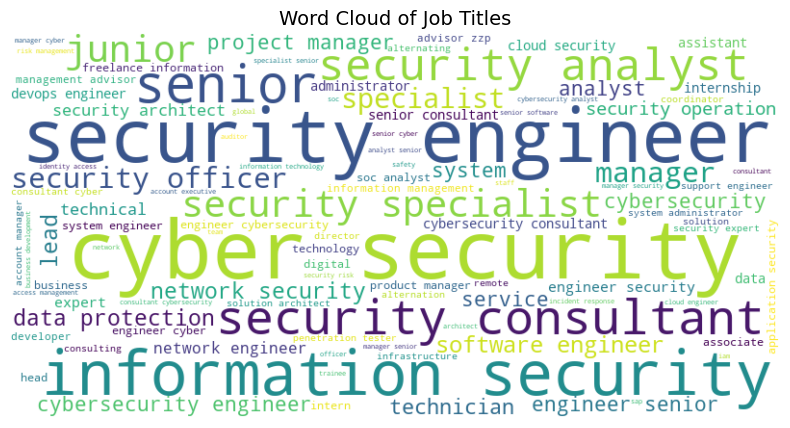

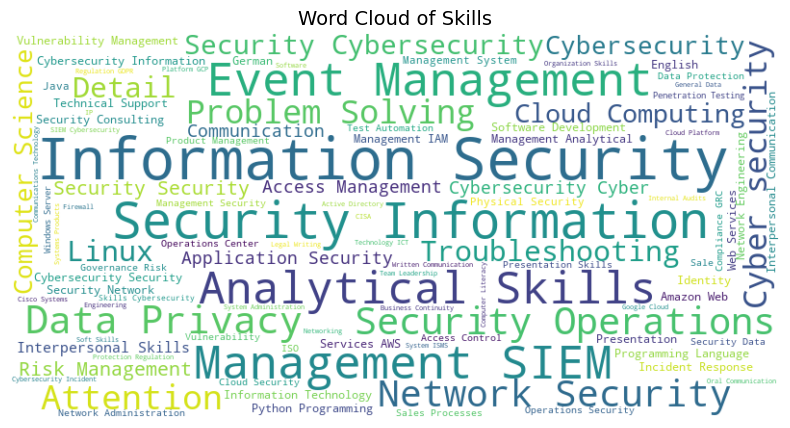

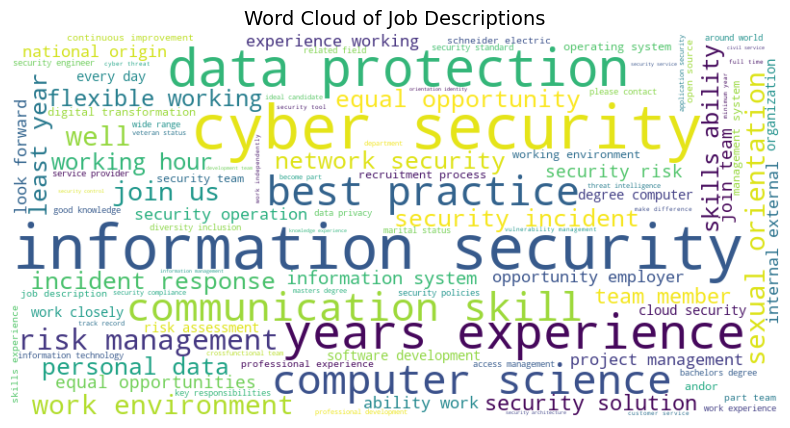

In [21]:
# Generate word clouds
plot_wordcloud(df["Cleaned_Title"], "Word Cloud of Job Titles")
plot_wordcloud(df["Skill"], "Word Cloud of Skills")
plot_wordcloud(df["Cleaned_Description"], "Word Cloud of Job Descriptions") 

### Analyzing locations

In [22]:
df["Location"].value_counts().head(10)

Location
Madrid, Community of Madrid, Spain     1047
Dublin, County Dublin, Ireland          886
Stockholm, Stockholm County, Sweden     710
Milan, Lombardy, Italy                  689
Athens, Attiki, Greece                  537
Paris, Île-de-France, France            525
Rome, Latium, Italy                     487
Barcelona, Catalonia, Spain             476
Warsaw, Mazowieckie, Poland             472
London, England, United Kingdom         461
Name: count, dtype: int64

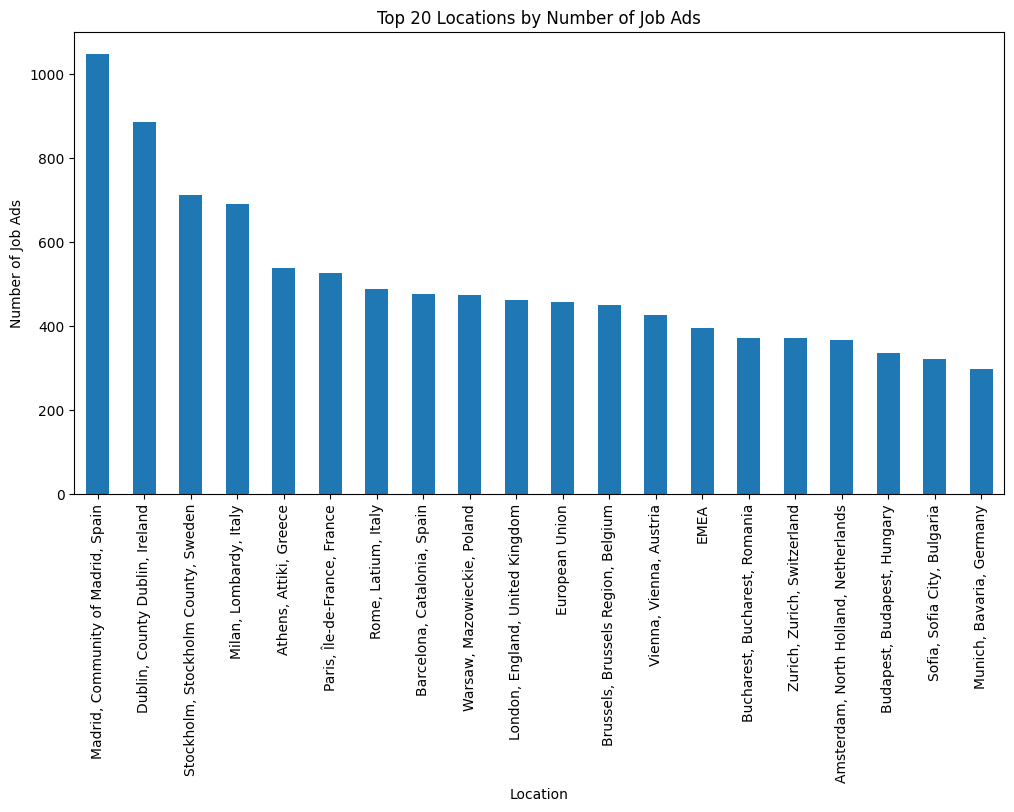

In [23]:
plt.figure(figsize=(12, 6))
df["Location"].value_counts().head(20).plot(kind="bar")
plt.xlabel("Location")
plt.ylabel("Number of Job Ads")
plt.title("Top 20 Locations by Number of Job Ads")
plt.xticks(rotation=90)
plt.show()


### Working on location
From the previous exploratory steps, we find out that the Location of the job is kind of specific, it shows the city, state and country or even a continent or a mix of these. For analysis purposes, we need an uniform column that reflects the same type of location without mixing cities with countries and so on. We'll try to filter these locations by country, because we can see that in most cases, the country is found at the end of the sentence of the field.

In [24]:
# Replace specific metropolitan areas with their respective countries in the Location column
df["Location"] = df["Location"].replace({
    "Greater Madrid Metropolitan Area": "Spain",
    "Greater Paris Metropolitan Region": "France",
    "Greater Barcelona Metropolitan Area": "Spain"
})

# Create a new column 'Country' by extracting the text after the last comma
df["Country"] = df["Location"].apply(lambda x: x.split(",")[-1].strip() if "," in x else x.strip())

# Exclude rows where Location contains "EMEA" or "European Union" (as these are not countries)
df = df[~df["Location"].str.contains("EMEA|European Union", na=False)]

# Display the top 20 countries to verify
df["Country"].value_counts().head(20)

Country
France            3424
Spain             2870
United Kingdom    2848
Germany           2744
Italy             2607
Netherlands       2569
Switzerland       1799
Sweden            1655
Ireland           1560
Poland            1398
Belgium           1197
Portugal          1105
Austria           1036
Romania            834
Greece             797
Hungary            597
Czechia            472
Bulgaria           459
Luxembourg         422
Denmark            358
Name: count, dtype: int64

In the following plot we'll find a more representative distribution of the jobs, as we filtered the location by country, and it turns out that the last plotted distribution was kind of mistaken, as we were not considering that each job location is stored with different specificity. Now, with an uniform location, we can see a more realistic distribution of the advertisements among Europe.

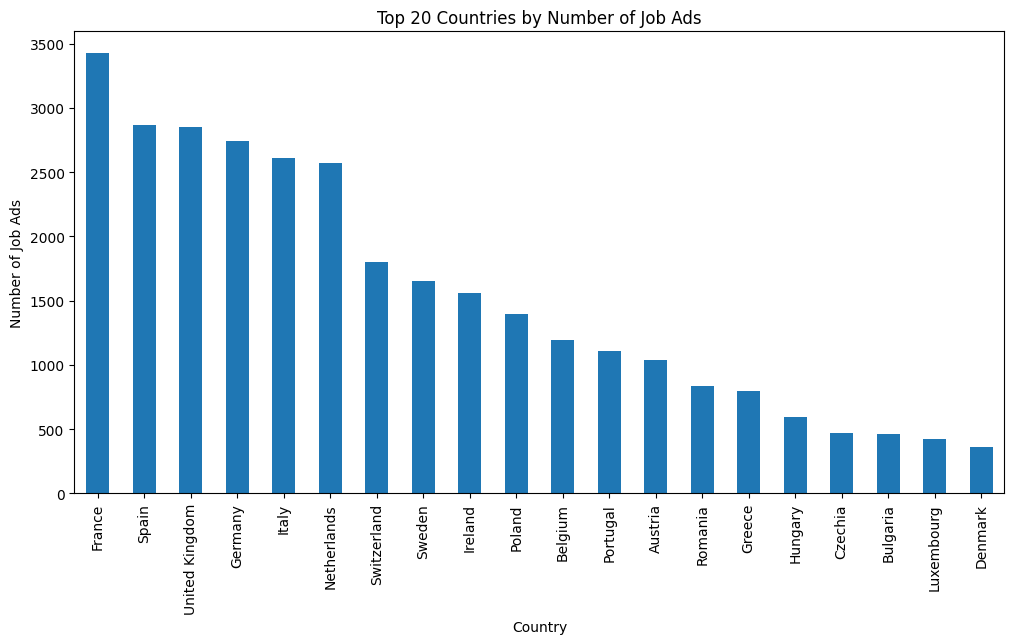

In [25]:
plt.figure(figsize=(12, 6))
df["Country"].value_counts().head(20).plot(kind="bar")
plt.xlabel("Country")
plt.ylabel("Number of Job Ads")
plt.title("Top 20 Countries by Number of Job Ads")
plt.xticks(rotation=90)
plt.show()

### Visualizing job ads in a choropleth map (Europe)
Seeing the frequencies of cybersecurity job ads displayed on a choropleth map offers different insights, such as understanding the the geographical distribution of demand and opportunities within the European cybersecurity job market currently. 


In [26]:
import geopandas as gpd

In [27]:
# Aggregate job counts by country
job_counts = df["Country"].value_counts().reset_index()
job_counts.columns = ["Country", "Job Count"]

In [28]:
# Load the shapefile for world countries
shapefile_path = "maps/ne_110m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)
# Filter for European countries
europe = world[world["CONTINENT"] == "Europe"]  # column name is "CONTINENT" in this dataset
europe = europe.merge(job_counts, how="left", left_on="NAME", right_on="Country")  # Use "NAME" for country names

In [29]:
# Fill NaN values in "Job Count" with 0
europe["Job Count"] = europe["Job Count"].fillna(0)

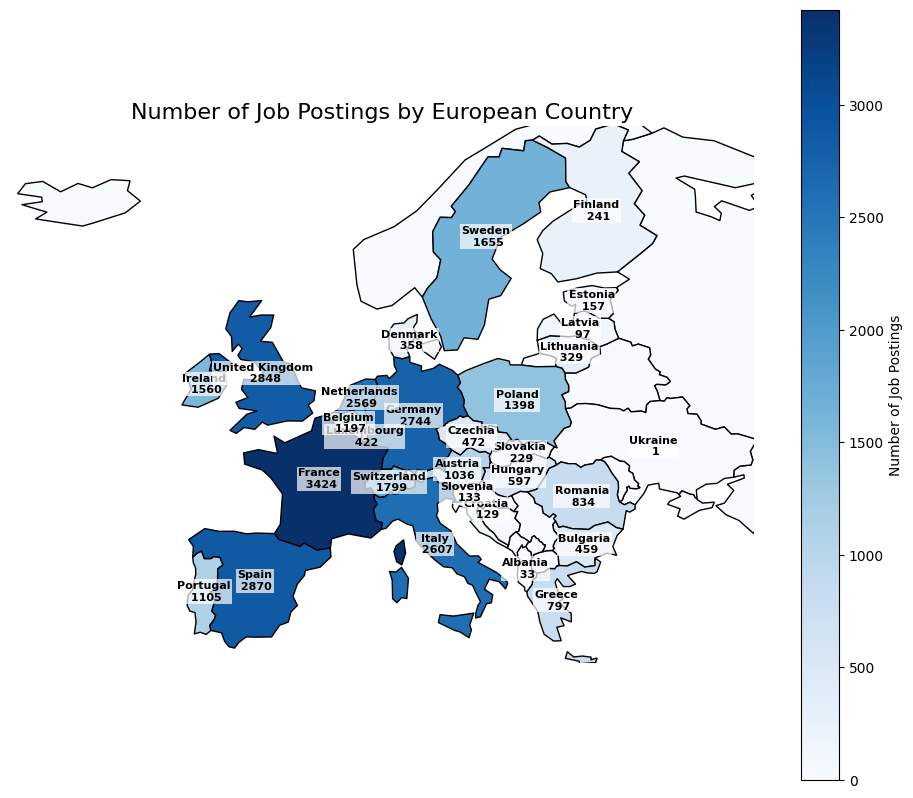

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the choropleth map
europe.plot(
    column="Job Count",
    ax=ax,
    legend=True,
    cmap="Blues",
    edgecolor="black",
    missing_kwds={"color": "lightgrey", "label": "No Jobs"},
    legend_kwds={"label": "Number of Job Postings", "orientation": "vertical"}
)

# Define approximate bounds for Europe (longitude: -25 to 40, latitude: 35 to 70)
ax.set_xlim(-25, 40)  # Longitude range
ax.set_ylim(35, 70)   # Latitude range

for idx, row in europe.iterrows():
    if row["Job Count"] > 0:  # Only label countries with jobs
        # Get the centroid of the country for label placement
        if row["NAME"] == "France":
            centroid_x, centroid_y = 2.0, 47.0
        else: 
            centroid = row.geometry.centroid
            centroid_x, centroid_y = centroid.x, centroid.y
        # Annotate the job count at the centroid
        ax.annotate(
            text=f"{row['NAME']}\n {int(row['Job Count'])}",  # Display country / number of ads
            xy=(centroid_x, centroid_y),  # Position of the label
            ha="center",  # Horizontal alignment: center
            va="center",  # Vertical alignment: center
            fontsize=8,
            color="black",
            weight="bold",
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", pad=1)  # Add a semi-transparent white background
        )

ax.set_title("Number of Job Postings by European Country", fontsize=16)
ax.set_axis_off()  # Remove axes for a cleaner map

plt.show()

### Analyzing skills required per job ad
Job ads usually list a set of skills required by the position. In our dataset, we can see this is contained in a sentence were skills are separated with comma. For more analysis and understanding of this feature, we'll process this column to have a version of skills which we can work with more easily.

In [31]:
def clean_and_standardize_skills(skills_str):
    if not isinstance(skills_str, str) or skills_str.strip() == "":
        return []  # Return empty list for empty or non-string values
    # Split by comma, strip whitespace, and standardize
    skills = [skill.strip() for skill in skills_str.split(",") if skill.strip()]
    # Standardize cyber security variations
    standardized_skills = []
    for skill in skills:
        skill = skill.lower()  # Convert to lowercase for consistency
        if any(var in skill for var in ["cybersecurity", "cyber-security", "cyber security"]):
            standardized_skills.append("cyber security")
        else:
            standardized_skills.append(skill)

    return standardized_skills

In [32]:
# Apply the cleaning function to the Skill column
df["Skills_List"] = df["Skill"].apply(clean_and_standardize_skills)
# Explode the list of skills into a separate row
all_skills = df["Skills_List"].explode().dropna().reset_index(drop=True)

In [33]:
# Filter out rows where Skills_List is empty or contains an empty list
filtered_df = df[df["Skills_List"].apply(lambda x: isinstance(x, list) and len(x) > 0)]
print("First rows of Skills_List:")
# Print the filtered DataFrame
print(filtered_df[["Skill", "Skills_List"]].head())

First rows of Skills_List:
                                 Skill                             Skills_List
0        Linux, Vulnerability Research         [linux, vulnerability research]
1  Security Consulting, Cloud Security   [security consulting, cloud security]
2                       Hyper-V, Linux                        [hyper-v, linux]
4  Cybersecurity, Information Security  [cyber security, information security]
5       Responsiveness, Access Control        [responsiveness, access control]


In [34]:
print("\nSkills and their frequencies:")
print(all_skills.value_counts().head(20))


Skills and their frequencies:
Skills_List
cyber security                                      5004
information security                                2132
security information and event management (siem)    1513
analytical skills                                   1429
troubleshooting                                     1245
linux                                               1129
communication                                       1079
data privacy                                        1074
network security                                    1002
attention to detail                                  888
security operations                                  835
problem solving                                      675
vulnerability                                        656
english                                              600
cloud computing                                      596
computer science                                     580
presentations                                

### Visualizing most required skills 
Though sometimes skills list whole fields such as cybersecurity or IT (not real skills), we're plotting the true distribution of what jobs in cybersecurity are currently requiring.

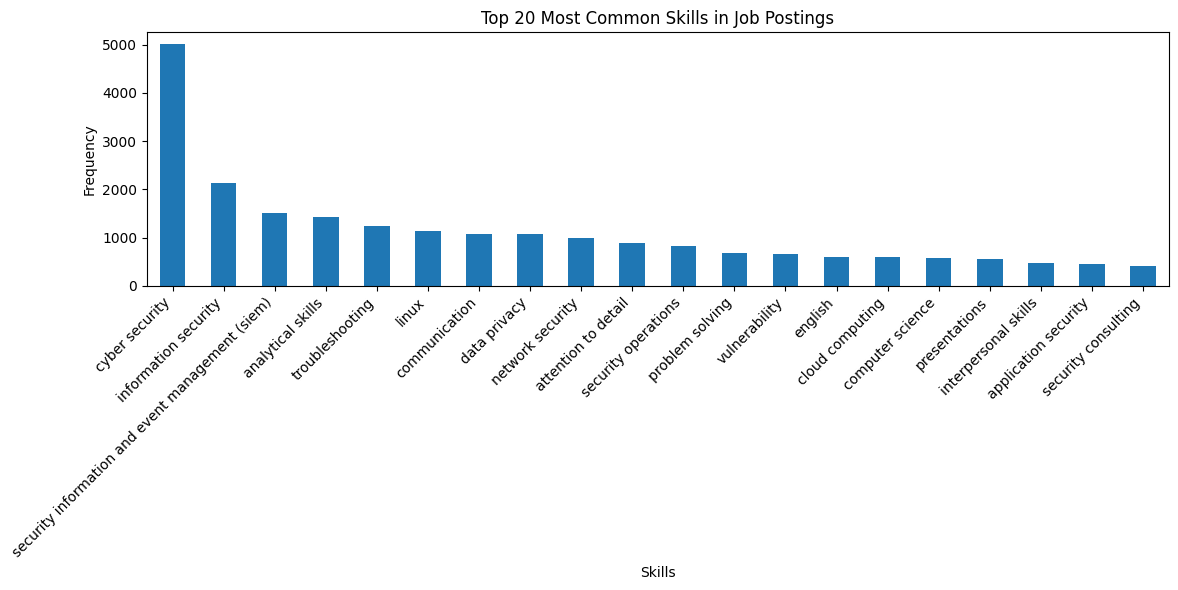

In [35]:
# Bar Chart of Top Skills
top_skills = all_skills.value_counts().head(20)
plt.figure(figsize=(12, 6))
top_skills.plot(kind="bar")
plt.title("Top 20 Most Common Skills in Job Postings")
plt.xlabel("Skills")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

For the current dataset, it shows that we're evaluating the majority of the job ads, where only less that 6% is not explicitly listing skills.

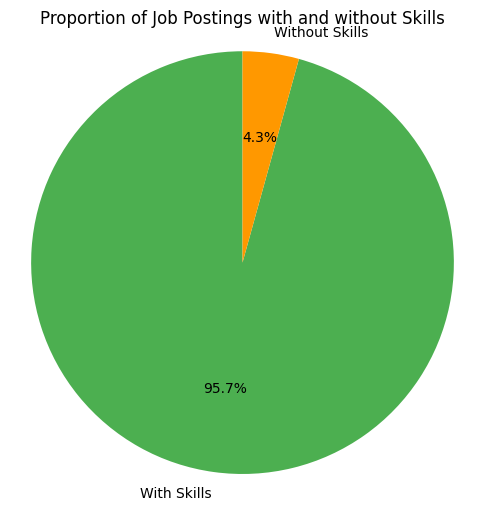

In [36]:
# Pie Chart of Jobs with vs. Without Skills
has_skills = (df["Skills_List"].str.len() > 0).value_counts()
plt.figure(figsize=(6, 6))
plt.pie(has_skills, labels=["With Skills", "Without Skills"], colors=["#4CAF50", "#FF9800"], autopct="%1.1f%%", startangle=90)
plt.title("Proportion of Job Postings with and without Skills")
plt.axis("equal")
plt.show()

### Finding insights from Descriptions
We'll use the cleaned Description column to identify the most common words or phrases, and then we'll plot the results for better visualization.

In [37]:
from collections import Counter

# Combine all cleaned descriptions into a single string
cleaned_text = " ".join(df["Cleaned_Description"].dropna())

# Tokenize and count word frequencies
word_counts = Counter(cleaned_text.split())

# Get the top 20 most common words
common_words = word_counts.most_common(20)

print("\nTop 20 most common words in job descriptions:")
for word, count in common_words:
    print(f"{word}: {count}")


Top 20 most common words in job descriptions:
security: 166046
work: 87557
experience: 82462
team: 79708
management: 65823
data: 56798
skills: 48844
information: 48267
support: 46831
business: 46795
working: 45264
development: 44533
knowledge: 43010
solutions: 41633
technical: 39792
role: 38085
company: 37013
us: 35821
systems: 35734
services: 33037


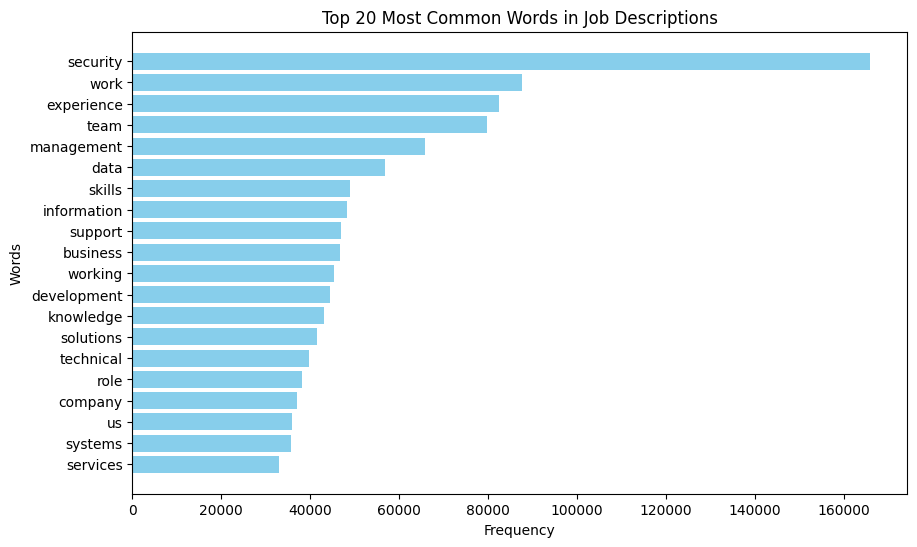

In [38]:
# Separate words and their counts
words, counts = zip(*common_words)

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(words, counts, color="skyblue")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Common Words in Job Descriptions")
plt.gca().invert_yaxis()  # Invert y-axis to show the highest frequency at the top
plt.show()

### Analyzing Job Titles
Identify the most common job titles to understand the demand for specific roles.

In [39]:
# Count the frequency of job titles
title_counts = df["Title"].value_counts()

# Display the top 15 job titles
top_titles=title_counts.head(15)
# Excluding "Freelance Information Management Advisor (ZZP)" from the list
top_titles = top_titles[top_titles.index != "Freelance Information Management Advisor (ZZP)"]
print("\nTop 15 Job Titles:")
print(top_titles)


Top 15 Job Titles:
Title
Cyber Security Engineer               195
Security Engineer                     127
Cyber Security Consultant             120
Cyber Security Analyst                118
Network Security Engineer             109
Network Engineer                       99
DevOps Engineer                        93
Information Security Officer           85
Cyber Security Specialist              82
Penetration Tester                     78
Security Operations Center Analyst     73
Soc Analyst                            68
Legal counel                           65
Product Manager - Cloud Native         64
Name: count, dtype: int64


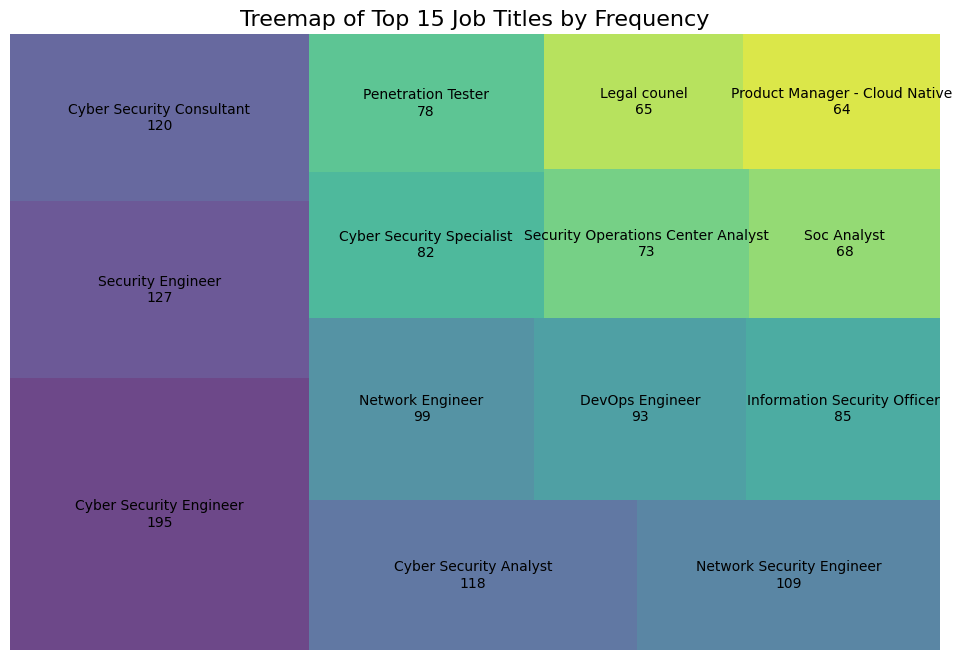

In [40]:
import squarify

sizes = top_titles.values  # Frequencies

# Combine job titles with their frequencies
labels = [f"{title}\n{freq}" for title, freq in zip(top_titles.index, top_titles.values)]

# Create the treemap showing frequencies together with job titles
plt.figure(figsize=(12, 8))
squarify.plot(
    sizes=sizes,
    label=labels,
    alpha=0.8,
    color=sns.color_palette("viridis", len(sizes))
)
plt.title("Treemap of Top 15 Job Titles by Frequency", fontsize=16)
plt.axis("off")  # Turn off the axis
plt.show()

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Vectorize job titles
vectorizer = TfidfVectorizer(stop_words='english')
title_matrix = vectorizer.fit_transform(df["Title"].dropna())

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42) 
kmeans.fit(title_matrix)

# Add cluster labels to the DataFrame
df["Title_Cluster"] = kmeans.labels_

# Display sample titles from each cluster
for cluster in range(3):
    print(f"Cluster {cluster}:")
    print(df[df["Title_Cluster"] == cluster]["Title"].head(10))

Cluster 0:
1                Junior Azure Cloud Security Consultant
5                                Security agent (M / F)
11                         ICT Risk & Security Analyst 
19                Junior Consultant IT-Security (m/w/d)
22                                Cloud Security Expert
24                      Information Security Consultant
25    IT Security Specialist in the field of informa...
33                          Network Security Specialist
36                            Product Security Officer*
38                                     SECURITY MANAGER
Name: Title, dtype: object
Cluster 1:
0                   Internship Vulnerability Researcher
3                              Junior Software Engineer
4     Alternation - Engineer Cybersecurity - Montpel...
6                                            Soc anayst
9     ALT 2025 - Apprenti(e) en Cybersecurity & Data...
10                                      AI data manager
13           Cybersecurity engineer - F/H - Alternation

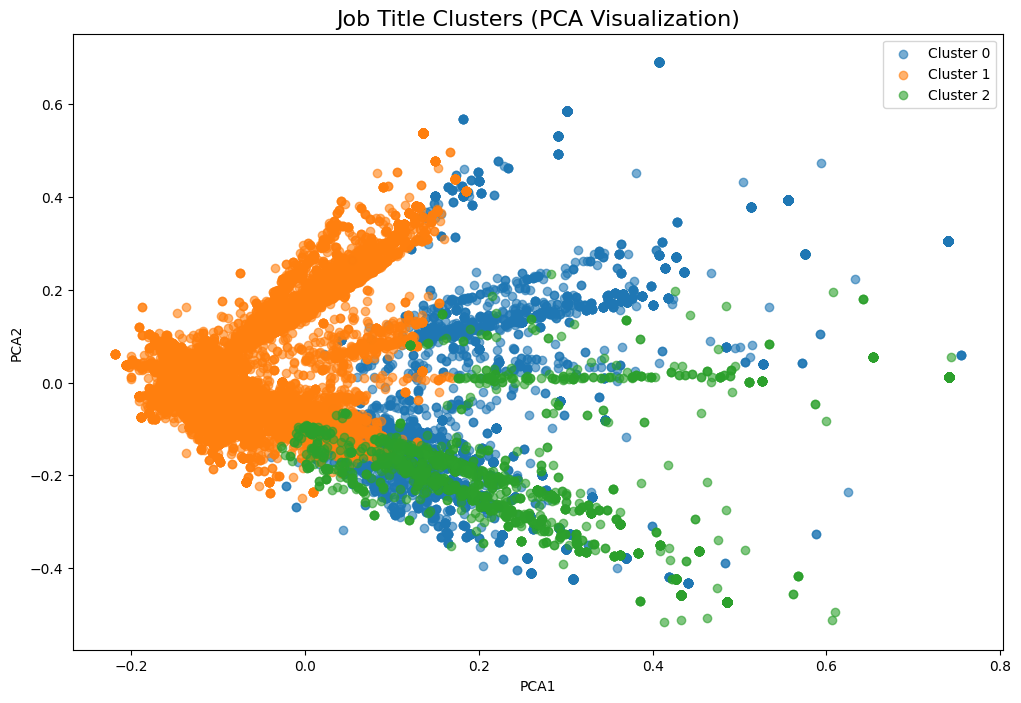

In [42]:
from sklearn.decomposition import PCA

# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2, random_state=42)
reduced_matrix = pca.fit_transform(title_matrix.toarray())

# Add the reduced dimensions to the DataFrame
df["PCA1"] = reduced_matrix[:, 0]
df["PCA2"] = reduced_matrix[:, 1]

# Plot the clusters
plt.figure(figsize=(12, 8))
for cluster in range(3):  
    cluster_data = df[df["Title_Cluster"] == cluster]
    plt.scatter(
        cluster_data["PCA1"], 
        cluster_data["PCA2"], 
        label=f"Cluster {cluster}", 
        alpha=0.6
    )

plt.title("Job Title Clusters (PCA Visualization)", fontsize=16)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.show()

### Storing state of the DataFrame and saving the last state ad a json file for backup purposes.

In [43]:
# store state of the DataFrame
with open('df_state.pkl', 'wb') as f:
        pickle.dump(df, f)